In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
#from root_numpy import array2root, root2array
import glob
import matplotlib.pyplot as plt
from time import strftime

In [2]:
def get_bkg_features(sets_of_npzs, weights, n_target_events=10000):
    """
    Gets a combined, weighted combination of events
    """
    weights /= np.sum(weights) # normalize
    print(f'weights: {weights}')
    n_events_per_set = (weights * n_target_events).astype(np.int32)

    print(f'n_events per set: {n_events_per_set}')

    X_combined = []
    for n_events, npzs in zip(n_events_per_set, sets_of_npzs):
        print(f'n_events: {n_events}')
        n_events_todo = n_events
        for npz in npzs:
            X = np.load(npz)['X'][:,:9]
            n_events_this_npz = X.shape[0]
            if n_events_this_npz > n_events_todo:
                X = X[:n_events_todo]
            X_combined.append(X)
            n_events_todo -= X.shape[0]
            if n_events_todo == 0: break
        else:
            print(f'Warning: reached end of set of files with n_events_todo={n_events_todo}')

    X_final = np.vstack(X_combined)
    assert len(X_final.shape) == 2
    assert X_final.shape[1] == 9
    return X_final

In [3]:
#labels = ['300to470', '470to600', '600to800', '800to1000', '1000to1400']
#labels = ['300to470', '470to600', '600to800', '800to1000', '1000to1400', 'genMET', 'DiLept_TuneCP5', '600to800', '800to1200', '1200to2500', '2500toInf', 'SingleLeptFromTbar_genMET', 'SingleLeptFromTbar_TuneCP5', 'SingleLeptFromT_TuneCP5']
labels = ['300to470', '470to600', '600to800', '800to1000', '1000to1400', 'genMET', 'DiLept_TuneCP5', '600to800', 'SingleLeptFromTbar_genMET', 'SingleLeptFromTbar_TuneCP5', 'SingleLeptFromT_TuneCP5']
crosssections = [6826.0, 552.6, 156.6, 26.32, 7.50, 22.45, 54.23, 1.821, 31.68, 108.7, 109.6]#10% factor applied on qcd300to470 is the uncertainty
sets_of_npzs = [ glob.iglob(f'data/bkg/*{l}*/*.npz') for l in labels ]
X_bkg = get_bkg_features(sets_of_npzs, crosssections)
y_bkg = np.zeros(X_bkg.shape[0])

weights: [8.64324044e-01 6.99715011e-02 1.98290573e-02 3.33269980e-03
 9.49667496e-04 2.84267137e-03 6.86672911e-03 2.30579268e-04
 4.01139550e-03 1.37638476e-02 1.38778077e-02]
n_events per set: [8643  699  198   33    9   28   68    2   40  137  138]
n_events: 8643
n_events: 699
n_events: 198
n_events: 33
n_events: 9
n_events: 28
n_events: 68
n_events: 2
n_events: 40
n_events: 137
n_events: 138


In [4]:
def get_sig_features(sets_of_npzs, weights, n_target_events=2500):
    """
    Gets a combined, weighted combination of events
    """
    weights /= np.sum(weights) # normalize
    print(f'weights: {weights}')
    n_events_per_set = (weights * n_target_events).astype(np.int32)

    print(f'n_events per set: {n_events_per_set}')

    X_combined = []
    for n_events, npzs in zip(n_events_per_set, sets_of_npzs):
        print(f'n_events: {n_events}')
        n_events_todo = n_events
        for npz in npzs:
            #X = np.load(npz)['X'][:,:13]
            X = np.load(npz)['X'][:,:9]
            #print(f'loading variables: {X.shape[0]}')
            #print(f'variables: {X}')
            X
            n_events_this_npz = X.shape[0]
            if n_events_this_npz > n_events_todo:
                X = X[:n_events_todo]
            X_combined.append(X)
            n_events_todo -= X.shape[0]
            if n_events_todo == 0: break
        else:
            print(f'Warning: reached end of set of files with n_events_todo={n_events_todo}')

    X_final = np.vstack(X_combined)
    assert len(X_final.shape) == 2
    assert X_final.shape[1] == 9
    return X_final

In [25]:
#labels_sig = ['mz250', 'mz300', 'mz350', 'mz400', 'mz450']
labels_sig = ['mz250', 'mz300', 'mz350']
#labels_sig = ['mz250']
#sig_xsec = [2542.87, 1403.216, 848.948]
#sig_xsec = [1,1,1,1,1]
sig_xsec = [1,1,1]
#sig_xsec = [1]
#labels_sig = ['mz250', 'mz350']
#sig_xsec = [2542.87, 848.948]
#sig_npzfiles = [ glob.iglob(f'/data/users/snabili/bdt/svj-bdt/files/signal/noTruthInfo/{l}*/*.npz') for l in labels_sig ]
sig_npzfiles = [ glob.iglob(f'/data/users/snabili/bdt/svj-bdt/files/signal/newsamples/{l}*/*.npz') for l in labels_sig ]
print(f' signal weights are: {sig_xsec}')
#X_signal = np.load('/data/users/snabili/bdt/svj-bdt/files/bkg/finaltreemakersamples/treemaker_mz350mDard10rinv0p3.npz')['X'][:,:9]
#y_signal = np.ones(sig_npzfiles.shape[0])
#print(f'signal files are: ,{sig_npzfiles}
X_signal = get_sig_features(sig_npzfiles, sig_xsec)
y_signal = np.ones(X_signal.shape[0])

 signal weights are: [1, 1, 1]
weights: [0.33333333 0.33333333 0.33333333]
n_events per set: [833 833 833]
n_events: 833
n_events: 833
n_events: 833


In [26]:
X = np.vstack((X_signal, X_bkg))
y = np.concatenate((y_signal, y_bkg)).astype(np.int8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

In [27]:
y_train

array([0, 0, 1, ..., 0, 1, 0], dtype=int8)

In [28]:
model = xgb.XGBClassifier(
    eta=.03, scale_pos_weight=y.shape[0]/np.sum(y),
    #max_depth=3,
    #n_estimators=850,
    max_depth=4,
    n_estimators=1000,

    )
model.fit(X_train, y_train)

# NTrees=850
# MinNodeSize=2.5%
# MaxDepth=3
# BoostType=AdaBoost
# AdaBoostBeta=0.5
# UseBaggedBoost
# BaggedSampleFraction=0.5
# SeparationType=GiniIndex
# nCuts=20


/home/snabili/miniconda3/envs/svj-bdt/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0299999993, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.999599839935974,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [29]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(y_test, y_pred)

array([[1443,  546],
       [ 129,  381]])

Text(0, 0.5, 'Sig efficiency')

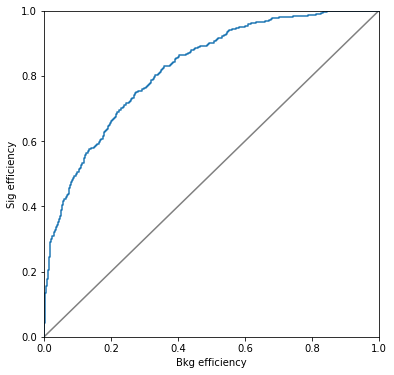

In [30]:
eff_bkg, eff_sig, cuts = roc_curve(y_test, y_prob)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.plot([0,1], [0,1], c='gray')
ax.plot(eff_bkg, eff_sig)
ax.set_ylim(0., 1.)
ax.set_xlim(0., 1.)
ax.set_xlabel('Bkg efficiency')
ax.set_ylabel('Sig efficiency')

In [42]:
i_wp = np.argmax(eff_bkg >= .05)
print(f'eff_sig: {eff_sig[i_wp]:.3f}, bkg_eff: {eff_bkg[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

i_wp = np.argmax(eff_bkg >= .275)
print(f'eff_sig: {eff_sig[i_wp]:.3f}, bkg_eff: {eff_bkg[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

eff_sig: 0.371, bkg_eff: 0.050, cut: 0.788
eff_sig: 0.747, bkg_eff: 0.276, cut: 0.499


 model.save_model(strftime('svjbdt_%b%d.json'))

In [43]:
auc(eff_bkg, eff_sig)

0.8226342925304861

In [44]:
y_prob_sig = y_prob[y_test == 1]
y_prob_bkg = y_prob[y_test == 0]

Text(0.5, 0, 'BDT score')

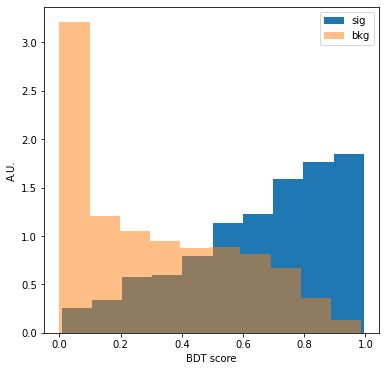

In [45]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

ax.hist(y_prob_sig, label='sig', density=True)
ax.hist(y_prob_bkg, label='bkg', alpha=.5, density=True)
ax.legend()
ax.set_ylabel('A.U.')
ax.set_xlabel('BDT score')

In [21]:
from root_numpy import array2root, root2array

ModuleNotFoundError: No module named 'root_numpy'

In [22]:
#corrmat = np.corrcoef(X.T)
corrmat = np.corrcoef(X)
#print(f'corrmat: {corrmat}')
corrmat = np.corrcoef(X.T)
#print('*'*50)
#print(f'corrmat: {corrmat}')

In [23]:
corrmat.shape

(9, 9)

/tmp/ipykernel_2875633/3363637621.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels, rotation=90)
/tmp/ipykernel_2875633/3363637621.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


NameError: name 'array2root' is not defined

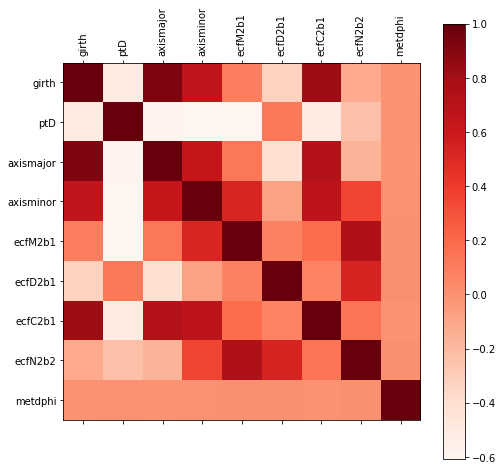

In [24]:
labels = ['girth', 'ptD', 'axismajor', 'axisminor', 'ecfM2b1', 'ecfD2b1', 'ecfC2b1', 'ecfN2b2', 'metdphi']
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
mshow = ax.matshow(corrmat, cmap=plt.cm.Reds)
ax.set_xticklabels(['']+labels, rotation=90)
ax.set_yticklabels(['']+labels)

cbar = fig.colorbar(mshow)
cbar
y_prob_sig.dtype = [('y_prob_sig', 'float32')]
y_prob_bkg.dtype = [('y_prob_bkg', 'float32')]
array2root(y_prob_sig,'test_signal.root', 'tre')
array2root(y_prob_bkg,'test_background.root', 'tre')

In [ ]:
#import numpy
#data = np.load("data/signal.npz")
#data = np.load("data/signal.npz")['X'][:,:1]
#print(f'data first item is: {data.items()}')
#data[0]
#print('*'*50)
#data[1]
#all = [('data', 'float32')]
#y_prob_bkg.dtype = [('y_prob_bkg', 'float32')]
#array2root(all, "test.root", "tree1")

In [ ]:
plt.cm.Reds

## Check model IO

In [20]:
model2 = xgb.XGBClassifier()
model2.load_model('svjbdt_Sep21.json')

In [21]:
model.predict_proba(X_test[:10])

array([[0.8196123 , 0.18038766],
       [0.67287016, 0.3271298 ],
       [0.9984967 , 0.00150326],
       [0.20984143, 0.79015857],
       [0.17375535, 0.82624465],
       [0.9924039 , 0.00759609],
       [0.16784364, 0.83215636],
       [0.9435164 , 0.05648363],
       [0.75425124, 0.24574874],
       [0.74996036, 0.25003964]], dtype=float32)

In [27]:
model2.predict_proba(X_test[:10])

array([[0.9848402 , 0.01515981],
       [0.8621958 , 0.1378042 ],
       [0.25562108, 0.7443789 ],
       [0.74413335, 0.25586662],
       [0.10223418, 0.8977658 ],
       [0.00329006, 0.99670994],
       [0.36756986, 0.63243014],
       [0.39677912, 0.6032209 ],
       [0.6682416 , 0.3317584 ],
       [0.06795782, 0.9320422 ]], dtype=float32)